# Introduction

Modern AI applications in urban planning, environmental monitoring, and disaster response rely on precise analysis of <b>georeferenced imagery</b>—high-resolution drone or satellite data embedded with spatial metadata. This module focuses on preparing such imagery for <b>semantic segmentation</b>, a technique critical for tasks like identifying buildings, land cover, or infrastructure in aerial datasets.

Semantic segmentation is the process of classifying every pixel in an image into a predefined category (e.g., "building," "vegetation," or "road"). For georeferenced imagery, this technique transforms raw drone or satellite data into detailed, actionable maps. Unlike object detection (bounding boxes) or classification (whole-image labels), segmentation provides fine-grained spatial understanding—critical for mapping infrastructure, tracking land use, or monitoring environmental changes.

<figure style="text-align: center">
  <img src="https://www.researchgate.net/publication/336934637/figure/fig4/AS:1141320089387015@1649123322409/Recognition-problems-related-to-generic-object-detection-a-image-level-object.png" width=400>
  <figcaption><i>Illustration of different computer vision use cases<br>
  Taken from: <a href="https://www.researchgate.net/publication/336934637_Deep_Learning_for_Generic_Object_Detection_A_Survey">researchgate.net</a></i></figcaption>
</figure>

<figure style="text-align: center">
  <img src="https://pub.mdpi-res.com/remotesensing/remotesensing-13-02450/article_deploy/html/images/remotesensing-13-02450-g002.png?1624441623" width=400>
  <figcaption><i>Illustration of different computer vision use cases in georeferenced imagery<br>
  Taken from: <a href="https://www.mdpi.com/2072-4292/13/13/2450">mdpi.com</a></i></figcaption>
</figure>

<b>You’ll learn to</b> collect, preprocess, and augment geospatial data, convert vector labels into raster masks, and build scalable data pipelines compatible with deep learning frameworks. By working with real-world datasets and APIs, you’ll bridge raw imagery to trainable models, mastering skills essential for deploying AI solutions in geospatial contexts.

Key elements covered:
- Georeferenced data handling (coordinate systems, alignment)
- Programmatic data preparation (APIs, automation)

# Task 1: Initial Setup

It's important to give google colab

In [ ]:
# Import the Google Colab drive module
from google.colab import drive

# Mount Google Drive to access files from '/content/drive'
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
# Install required Python packages:
# - rioxarray: for reading and writing geospatial raster data
# - boto3: AWS SDK for Python, used to interact with S3 buckets
!pip install rioxarray boto3 geopandas

## Importing Libraries

In [ ]:
import os  # Operating system utilities (file/directory handling)
from pathlib import Path  # Object-oriented filesystem paths

import pandas as pd  # Data manipulation and analysis (tables/dataframes)
import numpy as np  # Numerical operations and array handling
import geopandas as gpd  # Geospatial data analysis (vector data)
import rasterio as rio  # Geospatial raster data reading/writing
import rioxarray as rxr  # Raster data with xarray, geospatial metadata support

import boto3  # AWS SDK for Python (S3 data access)

pd.set_option('display.max_columns', None)  # Show all columns in pandas DataFrame output

## Preparing Directories

In [ ]:
# Set notebook and project directory paths
NB_DIR = Path("..")
PROJECT_DIR = NB_DIR

# Define data directories for different processing stages
DATA_DIR = PROJECT_DIR / 'data'
RAW_DATA_DIR = DATA_DIR / '0_raw'         # Raw data (downloaded files)
INTERIM_DATA_DIR = DATA_DIR / '1_interim' # Interim data (processed files)
PATCH_DIR = DATA_DIR / '2_patches'        # Patch data (image/mask patches)

# List of directories to create if they don't exist
folder_list = [
    DATA_DIR,
    RAW_DATA_DIR,
    INTERIM_DATA_DIR,
    PATCH_DIR,
]

# Create directories if they do not exist
for folder in folder_list:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Set random seed for reproducibility
RANDOM_SEED = 42

# Task 2: Data Collection and Preparation

To start with the project, we first need to collect the data. In this project, we are going to fetch both the image and the label. In real-world project, depending on how the team operate, sometimes the task of annotating the image is also the responsibility of the data scientist. However, in this case, we are going to assume that there are other role that responsible for the annotation, so we can focus on developing the model.

## Georeferenced Imagery

<figure style="text-align: center">
  <img src="https://www.earthdatascience.org/images/earth-analytics/raster-data/raster-concept.png" width=500>
  <figcaption><i>A raster is composed of a regular grid of cells. Each cell is the same size in the x and y direction. Source: Colin Williams, NEON.<br>
  Taken from: <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/">earthdatascience.org</a></i></figcaption>
</figure>

Georeferenced imagery is special since every pixel represents certain location on our earth, that is why not every annotating tools can be used to annotate georeferenced imagery. One open source tools that can handle this gracefully is called [QGIS](https://qgis.org).

<figure style="text-align: center">
  <img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEigG5troRMTI2UmSw9HyvICWtC3KLRtE-7w-CgiF4HVw9kNZ2Ahb6LWYQDPq6Ehx5_86SNSmL3sTRXOG07aQTAOU6lf5m6jjgaiSLqod6KcsJwWLZ2q44BZ-uiH0Hrk5-lys_YAk_tiBhSNtDWvNzBoJXHUT6dNoklpwrkIN5CUoX2lIOBKpI8U85BmKA/s708/digitizing%20building.gif" width=400>
  <figcaption><i>Digitizing/annotating georeferenced imagery in QGIS.<br>Taken from: <a href="https://www.geodose.com/2022/08/qgis-tips-tricks-how-digitize-perfect-building-footprint.html">geodose.com</a></i></figcaption>
</figure>

## Exploring The Data Source

This project will use https://source.coop as its data source.

> Source Cooperative is a data publishing utility that allows trusted organizations and individuals to share data using standard HTTP methods.
A core belief behind Source is that it should be much easier for people and organizations to share data on the open web.

To browse and access data from https://source.coop, we can use [AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html), [AWS SDK for Python (Boto3)](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html), and just recently, an [Unofficial Source Coop Python SDK & CLI](https://source.geocarpentry.org) was published.

<b>Note</b><br>
If you are using google colab, you have to install awscli first
```
!pip install aws configure
!pip install awscli
```

If you are running the notebook locally, please follow the guidance for [AWS CLI Installation](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html)

`data.source.coop` is publicly accessible, you might be able to use anonymous access by setting dummy credentials

In [ ]:
%%capture
# Install AWS CLI and configure package for accessing S3 buckets
!pip install aws configure
!pip install awscli

In [ ]:
# Set dummy AWS credentials for anonymous access to Source Cooperative S3
!aws configure set aws_access_key_id "fakekey"
!aws configure set aws_secret_access_key "fakesecret"

In [ ]:
# List the contents of the 'ai-challenge' folder in the 'open-cities' S3 bucket
# --endpoint-url specifies the custom endpoint for Source Cooperative
!aws s3 ls s3://open-cities/ai-challenge/ --endpoint-url=https://data.source.coop

                           PRE .source/
                           PRE test/
                           PRE train_tier_1/
                           PRE train_tier_2/
2023-04-03 17:41:07       1768 README.md
2021-08-26 20:21:57    1919684 documentation.pdf


In the script above, we use:
- `!` to the jupyter notebook we want to run a command inside a command prompt
- Then we wrote `aws` to indicate that we are going to use aws command
- In AWS CLI, we use `ls` to list the files and directory inside an s3 bucket
- `s3://open-cities/ai-challenge/` is the path of the bucket that we want to explore
- lastly we add an endpoint url `--endpoint-url=https://data.source.coop`

<div class="alert alert-block alert-success">
<h3>Excercise 1</h3>
Explore the data using awscli
</div>

Modify the aws cli command below to find your way into any `.tif` file inside the bucket<br>

`!aws s3 ls s3://open-cities/ai-challenge/ --endpoint-url=https://data.source.coop`

<details>
<summary>Click to see answer.</summary>

Sample answer:<br>
Create a new cell in the jupyter notebook and run this script<br>
```bash
!aws s3 ls s3://open-cities/ai-challenge/test/903bdd/ --endpoint-url=https://data.source.coop
```

Any path is an acceptable answer as long as it shows a `.tif` file in the result
</details>

### Exploring the bucket/data repository

To make it more python-native, let's explore the data repository using boto3. The script below will list all items inside `ai-challange/train_tier_1/`.

<b>You can change the `Prefix` to list the items inside different path</b>

In [ ]:
# Configure the boto3 S3 client to use the Source Cooperative endpoint with dummy credentials
s3 = boto3.client(
    's3',
    endpoint_url='https://data.source.coop',  # Custom endpoint for Source Cooperative
    aws_access_key_id='fakekey',              # Dummy access key for anonymous access
    aws_secret_access_key='fakesecret'        # Dummy secret key for anonymous access
)

bucket_name = 'open-cities'

# List objects in the specified bucket and prefix (folder)
response = s3.list_objects_v2(
    Bucket=bucket_name,
    Prefix='ai-challenge/train_tier_1/'       # Path to list objects under
)

files_data = []

# Iterate through the returned objects and collect relevant metadata
for obj in response.get('Contents', []):
    files_data.append({
        'Key': obj['Key'],                    # S3 object key (file path)
        'Size (bytes)': obj['Size'],          # File size in bytes
        # Human-readable file size (MB, KB, or B)
        'Size': f"{obj['Size']/(1024*1024):.2f} MB" if obj['Size'] >= 1024*1024 else
                f"{obj['Size']/1024:.2f} KB" if obj['Size'] >= 1024 else
                f"{obj['Size']} B",
        'Last Modified': obj['LastModified']  # Last modified timestamp
    })

In [ ]:
# If files_data is not empty, create a DataFrame and display it
if files_data:
    df = pd.DataFrame(files_data)  # Convert list of file metadata to DataFrame
    print(f"Found {len(df)} files")  # Print number of files found
    display(df)  # Display the DataFrame in notebook
else:
    print("No files found")  # Print message if no files found

Found 160 files


,Key,Size (bytes),Size,Last Modified
0,ai-challenge/train_tier_1/acc/665946-labels/66...,7955,7.77 KB,2021-08-26 20:28:50+00:00
1,ai-challenge/train_tier_1/acc/665946-labels/66...,10902820,10.40 MB,2021-08-26 20:34:37+00:00
2,ai-challenge/train_tier_1/acc/665946/665946.json,7501,7.33 KB,2021-08-26 20:34:06+00:00
3,ai-challenge/train_tier_1/acc/665946/665946.tif,3616008155,3448.49 MB,2021-08-26 20:34:27+00:00
4,ai-challenge/train_tier_1/acc/665946/665946.ti...,1168,1.14 KB,2021-08-26 20:33:13+00:00
...,...,...,...,...
155,ai-challenge/train_tier_1/znz/e52478-labels/e5...,2201,2.15 KB,2021-08-26 20:29:23+00:00
156,ai-challenge/train_tier_1/znz/e52478-labels/e5...,10625,10.38 KB,2021-08-26 20:30:12+00:00
157,ai-challenge/train_tier_1/znz/e52478/e52478.json,1748,1.71 KB,2021-08-26 20:34:15+00:00
158,ai-challenge/train_tier_1/znz/e52478/e52478.tif,431621975,411.63 MB,2021-08-26 20:29:10+00:00


<div class="alert alert-block alert-success">
<h3>Excercise 2</h3>
Explore the listed data
</div>

Answer these question:
1. What is the largest file size listed in the `DataFrame`?
1. What is the smallest file size listed in the `DataFrame`?

<details>
<summary>Click to see answer.</summary>

Sample answer:<br>
Create a new cell in the notebook and run this script<br>
```python
largest_key = df.sort_values('Size (bytes)').Key.tail(1).values[0]
largest_size = df.sort_values('Size (bytes)').Size.tail(1).values[0]
smallest_key = df.sort_values('Size (bytes)').Key.head(1).values[0]
smallest_size = df.sort_values('Size (bytes)').Size.head(1).values[0]

print(
f"""Largest item is: {largest_key} with size of {largest_size}
Smallest item is: {smallest_key} with size of {smallest_size}""")
```
</details>

Let's continue the exploration

In [10]:
# Extract extensions from the Key column
df['Extension'] = df['Key'].apply(lambda x: x.split('.')[-1] if '.' in x else 'no_extension')

# Get unique extensions and their counts
extension_counts = df['Extension'].value_counts()

# Print unique extensions
print("Unique file extensions:")
for ext, count in extension_counts.items():
    print(f".{ext}: {count} files")

Unique file extensions:
.json: 70 files
.geojson: 31 files
.tif: 31 files
.xml: 28 files


Looking at the result above, we can see there are 4 different file format. What's important for our project are `.tif` and `.geojson` files.

- The `.tif` files are the image. It is common to see georeferenced image in this format. Visually they are the same as `.jpg` file.
- The `.geojson` files are the label/annotation. As you may suspect, the format is very similar with normal `.json` files, but `.geojson` store some relevant geospatial information, such as the coordinate reference system (CRS).

## Fetching The Data

We will use data from area coded `mon` with item id of `493701`.<br>
Feel free to use a different area and item id to fetch a pair of image and label.

In [ ]:
# Set bucket and object key for image and label
area_name = 'mon'
item_id = '493701'
image_format = 'tif'
label_format = 'geojson'

# Construct S3 keys for image and label files
image_key = f'ai-challenge/train_tier_1/{area_name}/{item_id}/{item_id}.{image_format}'
label_key = f'ai-challenge/train_tier_1/{area_name}/{item_id}-labels/{item_id}.{label_format}'

# Loop through image and label keys to download each file
for my_object, format in zip([image_key, label_key], [image_format, label_format]):
    dest_path = f'{RAW_DATA_DIR}/{item_id}.{format}'  # Destination path for saving file
    if not Path(dest_path).exists():
        try:
            print(f"Downloading {item_id}.{format}...")  # Notify download start
            response = s3.get_object(Bucket=bucket_name, Key=my_object)  # Fetch file from S3
            file_content = response['Body'].read()  # Read file content
            with open(f'{RAW_DATA_DIR}/{item_id}.{format}', 'wb') as f:
                f.write(file_content)  # Write content to local file
            print("File downloaded")  # Notify download complete
        except Exception as e:
            print(f"Error downloading file: {e}")  # Print error if download fails
    else:
        print(f"{dest_path} already exist, skipping download...")  # Skip if file already exists

File downloaded
File downloaded


In [12]:
# Open image with rioxarray
rds = rxr.open_rasterio(
    str(RAW_DATA_DIR/f'{item_id}.{image_format}'),
    driver='GTiff'
)

# Open label with geopandas
label_gdf = gpd.read_file(str(RAW_DATA_DIR/f'{item_id}.{label_format}'))

In [13]:
rds

<xarray.DataArray (band: 4, y: 21783, x: 22333)> Size: 2GB
[1945918956 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 179kB 3.02e+05 3.02e+05 ... 3.03e+05 3.03e+05
  * y            (y) float64 174kB 7.005e+05 7.005e+05 ... 6.996e+05 6.996e+05
    spatial_ref  int64 8B 0
Attributes: (12/13)
    TIFFTAG_SOFTWARE:  APS - Menci Software - www.menci.com
    TIFFTAG_DATETIME:  25-08-2018 09:57:12
    LL_LAT:            6.32629460897868
    LL_LON:            -10.79217504000558
    LR_LAT:            6.326332202763627
    LR_LON:            -10.78124386562269
    ...                ...
    UL_LON:            -10.792204876798666
    UR_LAT:            6.334984563027563
    UR_LON:            -10.781273520664838
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0

In [14]:
label_gdf.head(2)

,building,scene_id,scene_area,addr:city,addr:community,building:levels,building:material,min_height,roof:material,source,building:roof,comment,name,religion,addr:street,amenity,shop,abandoned,layer,access,fee,operator,toilets:disposal,toilets:handwashing,bed_count,dispensing,emergency,opening_hours,operator_name,drinking_water,man_made,operational_status,pump,geometry
0,yes,5b83a514c8e197000a93403f,mon,Monrovia,Doe Community,1,cement_block,0.38,None,Open Cities Monrovia - HOT Field Survey,metal,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-10.78665 6.33194, -10.78657 6.3319,..."
1,yes,5b83a514c8e197000a93403f,mon,Monrovia,Doe Community,1,cement_block,None,None,Open Cities Monrovia - HOT Field Survey,metal,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-10.7871 6.33061, -10.78701 6.33056,..."


In [ ]:
# Print the Coordinate Reference System (CRS) of the raster image
print(rds.rio.crs)

# Print the CRS of the label GeoDataFrame
print(label_gdf.crs)

EPSG:32629
EPSG:4326


Notice that the ID of the CRS for the image and the label are different.
- The image CRS is in `EPSG: 32629`
- The label CRS in in `EPSG: 4326`

<figure style="text-align: center">
  <img src="https://www.esri.com/arcgis-blog/wp-content/uploads/2022/02/grid2.png" width=400>
  <figcaption><i>Illustration of the same point being represented in different coordiate reference systems (CRS).<br>
  Taken from: <a href="https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/gcs_vs_pcs">esri.com</a></i></figcaption>
</figure>

What's tricky about spatial data is they can have a different CRS. A different CRS can lead to misalignment when we try to visualize them.
So to make sure they are aligned, we need to <u>project</u> the label's CRS into the image's CRS before visualizing them.

In [16]:
if label_gdf.crs != rds.rio.crs:
    plot_gdf = label_gdf.to_crs(rds.rio.crs)
else:
    plot_gdf = label_gdf

## Visualize The Image

In [ ]:
%%capture
# Install earthpy: a Python package for visualizing and working with spatial raster and vector data
!pip install earthpy

In [18]:
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt
import earthpy.plot as ep

Visualizing the image and the label
It may take a while...


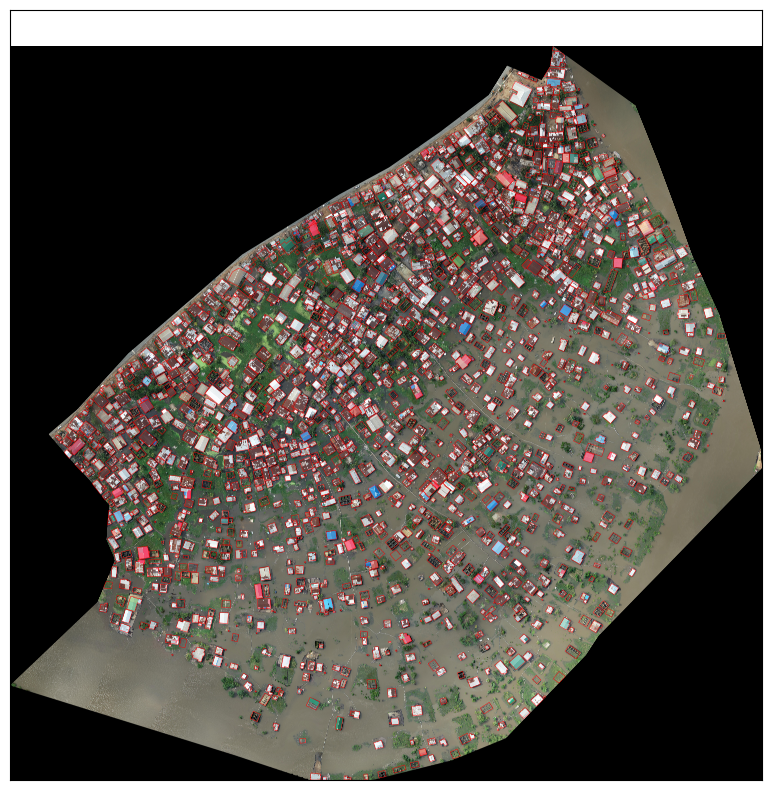

In [ ]:
print("Visualizing the image and the label")
print("It may take a while...")

# Create a matplotlib figure and axis for plotting
fig, ax = plt.subplots(figsize=(10,10))

# Get the spatial extent of the raster for correct georeferenced plotting
plot_extent = plotting_extent(
    rds[0],
    rds.rio.transform()
)

# Plot the RGB bands of the raster image
ep.plot_rgb(
    rds.values,
    rgb=[0, 1, 2],
    ax=ax,
    extent=plot_extent
)

# Overlay the building boundaries from the GeoDataFrame on top of the image
plot_gdf.boundary.plot(ax=ax, linewidth=0.3, color='red')

# Display the plot
plt.show()

<div class="alert alert-block alert-success">
<h3>Excercise 3</h3>
Explore the label
</div>

How many building detected in the image above?

<details>
<summary>Click to see answer.</summary>

Sample answer:<br>
Create a new cell in the jupyter notebook and run this script<br>
```python
print(f"There are {len(label_gdf)} buildings detected!")
```
</details>

# Task 3: Data Preparation

## Convert to RGB
If you notice, our `rds` contain 4 bands, this is quite common in drone imagery product, the bands are usually: <span style="color:red">red</span>, <span style="color:green">green</span>, <span style="color:blue">blue</span>, and alpha (or sometimes near-infrared). In that order.

For our model later, we will only need 3 bands, RGB. So first, we need to extract the image as RGB image.

In [ ]:
# Select only the R, G, B bands from the raster data (exclude alpha/NIR)
rgb_data = rds.isel(band=[0, 1, 2])  # Select R, G, B bands

# Define the output path for the RGB image
rgb_img_path = INTERIM_DATA_DIR/f'{item_id}_rgb.{image_format}'

# Check if the RGB image already exists
if not rgb_img_path.exists():
    # Export the selected RGB bands as a 3-band GeoTIFF
    print(f"Saving rasterized label to {rgb_img_path}")
    rgb_data.rio.to_raster(
        str(rgb_img_path),
        driver='GTiff',
        compress='lzw'
    )
else:
    # Skip export if file already exists
    print(f"{rgb_img_path} already exists, skipping the process")

Saving rasterized label to ../data/1_interim/493701_rgb.tif


## Rasterize Label

Our label is in <b>vector</b> format while our deep learning process later will need it in <b>raster</b> format.<br>
So, let's turn our label from vector to raster.

In [21]:
from rasterio.features import rasterize, geometry_mask

In [ ]:
# Define the output path for the rasterized mask
path_exp_target = INTERIM_DATA_DIR / f"{item_id}_mask.{image_format}"

# Export clipped label as raster mask if it doesn't already exist
if not path_exp_target.exists():
    # Open the source raster image to get its shape, CRS, and transform
    with rio.open(RAW_DATA_DIR / f'{item_id}.{image_format}') as src:
        # Reproject the label GeoDataFrame to match the raster's CRS
        sample_label = label_gdf.to_crs(src.crs)
        geometry = sample_label.geometry

        # Create a binary mask from the vector geometry, matching the raster's shape
        mask = geometry_mask(geometry, out_shape=src.shape, transform=src.transform, invert=True)

        # Assign a specified RGB value to the areas within the shapefile
        label_value = (255, 255, 255)  # RGB value for the label (white)
        mask_rgb = np.zeros((src.height, src.width, 3), dtype=np.uint8)  # Initialize RGB mask
        mask_rgb[mask] = label_value  # Set label pixels to white

        # Transpose mask_rgb to (channels, height, width) for rasterio
        mask_rgb = np.transpose(mask_rgb, (2, 0, 1))

    # Save the mask as a raster GeoTIFF
    print(f"Saving rasterized label to {path_exp_target}")
    with rio.open(
        path_exp_target, 'w', driver='GTiff', width=src.width, height=src.height,
        count=3, crs=src.crs, transform=src.transform, dtype=rio.uint8, compress='lzw'
        ) as dst:
        dst.write(mask_rgb)
else:
    # Skip export if mask already exists
    print(f"{path_exp_target} already exists, skipping the process")

Saving rasterized label to ../data/1_interim/493701_mask.tif


## Patchify Training Data

Another thing that make georeferenced imagery special is that it is usually relatively big in size (`mon/493701` is around 230 mb) and normally we only have one image (or a few).
This lead to a problem if we want to develop a deep learning model.
1. Deep learning usually require quite a lot of training sample, one sample is definitely not enough.
1. Even if we try to train the deep learning model, it will be very tricky to fit an image that huge into memory (especially for training).

That is why, we need to make an additional step to turn our one image, into <b>patches</b>.

In [23]:
# On linux, you may need to install GDAL system packages
!apt-get install -y gdal-bin libgdal-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgdal-dev is already the newest version (3.8.4+dfsg-1~jammy0).
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.4+dfsg-1~jammy0 [605 kB]
Fetched 5,168 kB in 4s (1,299 kB/s)
Selecting previously unselected pa

In [24]:
%%capture
!pip install GeoPatch==1.1.1

In [ ]:
# GeoPatch is a Python library for extracting geospatial image and label patches from large raster datasets.
# It is commonly used to split big drone/satellite images and their masks into smaller, model-ready tiles for deep learning.
from GeoPatch import TrainPatch

In [ ]:
# Set patch size and stride length for extracting image tiles
patch_size = 512
stride_dist = patch_size  # Non-overlapping patches

# Prepare paths for the RGB image and rasterized mask
image_path = INTERIM_DATA_DIR / f"{item_id}_rgb.{image_format}"
mask_path = INTERIM_DATA_DIR / f"{item_id}_mask.{image_format}"

# Initialize TrainPatch to extract patches from image and mask
patch = TrainPatch(
    image=str(image_path),      # Path to RGB image
    label=str(mask_path),       # Path to rasterized mask
    patch_size=patch_size,      # Size of each patch (pixels)
    stride=stride_dist,         # Stride between patches
    channel_first=True          # Output patches in (channels, height, width) format
)

# Display shape and size of the input image
patch.data_dimension()

# Display number of original image patches that will be generated
patch.patch_info()

# Save extracted patches to PATCH_DIR, only for areas overlapping with label
patch.save_Geotif(str(PATCH_DIR), only_label=True)

############################################
 the shape of image is: (3, 21783, 22333) 
 the shape of label is: (21783, 22333) 
############################################
       
#######################################################################################
The effective X-dimension of the input data for patch generation is from 0 to 21504
The effective Y-dimension of the input data for patch generation is from 0 to 22016
The number of total non-augmented patches that can be generated
based on patch size (512*512) and stride (512) is "1722"
#######################################################################################
                                                                        


Patch Counter:  57%|█████▋    | 989/1722 [00:32<00:23, 30.60 Patch/s]

#######################################################################################
989 patches, which are %57 of totall patches, are saved as ".tif" format in "/content\../data/2_patches"
#######################################################################################


In [ ]:
from glob import glob

# Get list of all label mask files (TIF format) in the label patch directory
label_list = glob(str(PATCH_DIR/"label/*.tif"))

# Get list of all image patch files (TIF format) in the patch directory
patch_list = glob(str(PATCH_DIR/"patch/*.tif"))

# Print the number of label masks found
print(f"Found {len(label_list)} label")
# Print the number of image patches found
print(f"Found {len(patch_list)} patch")

Found 989 label
Found 989 patch


<div class="alert alert-block alert-success">
<h3>Excercise 4</h3>
Count of patch
</div>

You may notice during the process, the number of total non-augmented patches doesn't match the number of total image generated.<br>
Why do you think is that?

<details>
<summary>Click to see answer.</summary>
Look at the image visualized on the previous section. You may notice, not every area are covered by the label.
When we save the patch, we pass `True` for the `only_label` parameter. This ensure only images that overlap with the label extracted as our patch. Some of the area that is not covered by any label wont be extracted, hence the difference.
</details>

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset

import albumentations as A  # Powerful image augmentation library for computer vision tasks

from random import randint

## Create Custom Dataset

<div class="alert alert-block alert-info">
A custom dataset structures raw data for your AI task. For building segmentation with drone imagery, our <code>BuildingsDroneDataset</code> handles:

<strong>Key Components:</strong>
- <b>Paired Geospatial Data:</b> Loads aligned TIF patches (drone imagery) and masks (building labels) from directories
- <b>Data Integrity:</b> Automatically verifies patch-label count matches to prevent training errors
- <b>Augmentation Pipeline:</b> Applies spatial/color transforms to both images <i>and</i> masks simultaneously using Albumentations
- <b>Geospatial Processing:</b> Maintains rasterio-compatible TIF handling while converting to PyTorch tensors
- <b>Visual QA:</b> Built-in <code>plot_pair()</code> method to inspect image-mask alignment

Like teaching a model to "see" buildings, this dataset ensures pixel-aligned pairs of aerial scans and their ground truths - whether analyzing urban expansion or disaster-damaged structures.
</div>

In [ ]:
# Define BuildingsDroneDataset class
class BuildingsDroneDataset(Dataset):
    """Dataset for building segmentation from drone imagery.

    Args:
        patch_dir (str): path to patch images folder (TIF format)
        label_dir (str): path to label masks folder (TIF format)
        augmentation (albumentations.Compose): data transformation pipeline
        preprocessing (albumentations.Compose): data preprocessing
    """

    def __init__(
        self,
        patch_dir,
        label_dir,
        augmentation=None,
        preprocessing=None,
    ):
        # Get paths to all TIF files in the directories
        self.patch_paths = [os.path.join(patch_dir, file_name)
                          for file_name in sorted(os.listdir(patch_dir))
                          if file_name.endswith('.tif')]

        self.label_paths = [os.path.join(label_dir, file_name)
                           for file_name in sorted(os.listdir(label_dir))
                           if file_name.endswith('.tif')]

        # Verify that we have matching number of patches and labels
        assert len(self.patch_paths) == len(self.label_paths), \
            f"Number of patches ({len(self.patch_paths)}) and labels ({len(self.label_paths)}) don't match"

        self.augmentation = augmentation  # Albumentations augmentation pipeline
        self.preprocessing = preprocessing  # Albumentations preprocessing pipeline

    def __getitem__(self, i):
        # Read TIF images using rasterio
        with rio.open(self.patch_paths[i]) as patch_file:
            # Read all bands and transpose to (channels, height, width)
            patch = patch_file.read()
            # Convert to (height, width, channels) for albumentations
            patch = np.transpose(patch, (1, 2, 0))

        with rio.open(self.label_paths[i]) as label_file:
            # Assume mask is single channel
            mask = label_file.read(1)

        # Ensure mask has values 0 and 1 only
        mask = (mask > 0).astype(np.float32)

        # Apply augmentations if provided
        if self.augmentation:
            sample = self.augmentation(image=patch, mask=mask)
            patch, mask = sample['image'], sample['mask']

        # Apply preprocessing if provided
        if self.preprocessing:
            sample = self.preprocessing(image=patch, mask=mask)
            patch, mask = sample['image'], sample['mask']

        # Convert numpy arrays to PyTorch tensors
        patch = torch.from_numpy(patch)
        mask = torch.from_numpy(mask)

        return patch, mask

    def __len__(self):
        # Return total number of samples
        return len(self.patch_paths)

    def plot_pair(self, idx=None):
        # Plot a random or specified image-mask pair for visual inspection
        if idx is not None:
            idx = idx
        else:
            idx = randint(0, len(self)-1)
        _, ax = plt.subplots(1, 2, figsize=(8, 4))

        img, mask = self[idx]

        # Convert tensors back to numpy for plotting
        img = img.numpy()
        mask = mask.numpy()

        # Handle different dimensions based on preprocessing
        if len(img.shape) == 3 and img.shape[0] == 3:  # CHW format
            img = np.transpose(img, (1, 2, 0))  # Convert to HWC for plotting

        ax[0].imshow(img)
        ax[0].set_title("Drone Image")

        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title("Building Mask")

        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        plt.suptitle(f"Sample {idx}")
        plt.tight_layout()


## Augmentation and Preprocessing

<div class="alert alert-block alert-info">

<u>Data Augmentation (Training Only):</u>
- <b>Spatial Transforms:</b> Random 90° rotations/flips (preserves geospatial alignment)
- <b>Drone-specific Strategy:</b> Mimics real-world variations (different flight angles, orientations)
- <b>Mask Preservation:</b> Applied simultaneously to images <i>and</i> masks via Albumentations

<u>Essential Preprocessing:</u>
- <b>Normalization:</b> Scales pixel values to [0,1] range (<code>to_float_and_normalize</code>)
- <b>Channel Formatting:</b> Converts HWC → CHW for PyTorch compatibility (<code>transpose_to_chw</code>)
- <b>Mask Safety:</b> Explicit float32 conversion prevents dtype issues in loss calculations

</div>

In [ ]:
# Define augmentation and preprocessing functions

def get_training_augmentation():
    """
    Simple augmentation pipeline for drone imagery training data.
    Applies random spatial transformations to increase data diversity.
    """
    train_transform = [
        # Randomly flip images horizontally
        A.HorizontalFlip(p=0.5),
        # Randomly flip images vertically
        A.VerticalFlip(p=0.5),
        # Randomly rotate images by 90 degrees
        A.RandomRotate90(p=0.5),
    ]
    return A.Compose(train_transform)

def get_preprocessing():
    """
    Simple preprocessing function for drone imagery.

    Returns:
        Preprocessing transform for normalization and channel reordering.
    """
    # Convert image to float32 and normalize pixel values to [0, 1]
    def to_float_and_normalize(image, **kwargs):
        return image.astype(np.float32) / 255.0

    # Rearrange image axes from HWC to CHW format for PyTorch
    def transpose_to_chw(image, **kwargs):
        return image.transpose(2, 0, 1)

    # Ensure mask is float32 for compatibility with loss functions
    def to_float32(mask, **kwargs):
        return mask.astype(np.float32)

    _transform = [
        # Scale image pixels to [0,1] range
        A.Lambda(image=to_float_and_normalize),
        # Convert image to channel-first format
        A.Lambda(image=transpose_to_chw),
        # Convert mask to float32
        A.Lambda(mask=to_float32),
    ]
    return A.Compose(_transform)

In [ ]:
# Create dataset with augmentation and preprocessing
# - patch_dir: directory containing image patches
# - label_dir: directory containing mask patches
# - augmentation: Albumentations pipeline for random flips/rotations
# - preprocessing: normalization and channel reordering for PyTorch
dataset = BuildingsDroneDataset(
    patch_dir=PATCH_DIR/'patch',
    label_dir=PATCH_DIR/'label',
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing()
)


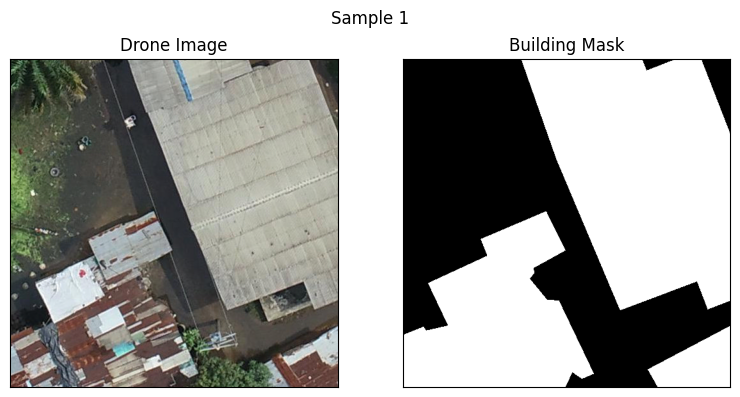

In [32]:
# Visualize a sample image and mask
sample_idx = 1 # Change this to see different samples
dataset.plot_pair(sample_idx)

## Data Split

Next, we want to split the data into training and validation.

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# Split dataset into training and validation (80/20 split)
indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42
)

In [35]:
# Create subset datasets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)} (80%)")
print(f"Validation set size: {len(val_dataset)} (20%)")

Total dataset size: 989
Training set size: 791 (80%)
Validation set size: 198 (20%)


## Turn loaded images into DataLoader
Turning our Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

In [36]:
# Create DataLoaders for training
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [37]:
# Example of iterating through the DataLoader
for i, (images, masks) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image shape: {images.shape}")
    print(f"  Mask shape: {masks.shape}")

    # Just process a few batches for demonstration
    if i >= 2:
        break

Batch 0:
  Image shape: torch.Size([8, 3, 512, 512])
  Mask shape: torch.Size([8, 512, 512])
Batch 1:
  Image shape: torch.Size([8, 3, 512, 512])
  Mask shape: torch.Size([8, 512, 512])
Batch 2:
  Image shape: torch.Size([8, 3, 512, 512])
  Mask shape: torch.Size([8, 512, 512])


# 🎉 Congratulations on Completing the Module! 🎉

Well done! You’ve mastered the critical steps of collecting, preprocessing, and preparing drone imagery for deep learning. Now, let’s solidify your skills with a practical task that mirrors real-world scenarios.

Here's a summary of what we did in this module
1. **Data Collection & Preprocessing**  
   - Download the dataset.
   - Convert vector labels into raster masks.
   - Handle geospatial metadata (e.g., coordinate systems, image alignment).
1. **Dataset Creation**
   - Created a dataset that compatible with PyTorch model.
1. **Augmentation & Analysis**  
   - Implement aerial-specific augmentations (e.g., rotation, flips, brightness/contrast adjustments for varying lighting conditions).  
   - Visualize samples to verify label-mask alignment post-augmentation.

# 🚀 Module Task: Prepare a New Dataset for Building Segmentation

## Task
Using a different dataset (see below for alternatives), replicate and adapt the pipeline you built in this module. Feel free to use any dataset if you have one.


## Alternative datasets
1. The [Landcover.ai Dataset](https://landcover.ai.linuxpolska.com) (aerial imagery for land cover segmentation)
1. [SpaceNet 3: Road Network Detection](https://spacenet.ai/spacenet-roads-dataset/)
1. [DOTA: A Large-scale Dataset for Object Detection in Aerial Images](https://ieee-dataport.org/documents/dota)
1. [Sentinel-2 Cloud Cover Segmentation Dataset](https://source.coop/radiantearth/cloud-cover-detection-challenge)

**Why This Task?**  
- **Skill Reinforcement:** Deepen your understanding of geospatial data handling, a critical skill for drone-based ML.
- **Pipeline Adaptability:** Practice modifying existing code for new data sources—a common task in industry projects.

**You’re ready for this!** Mastering dataset preparation ensures you can tackle any aerial imagery project, from disaster response to environmental monitoring.

**See you in the next module!**

## Copy Processed Data to Google Drive

We will copy the processed data to google drive so we can use it in the next module during training.

In [38]:
import shutil


# Define source and destination directories
src_dir = str(DATA_DIR)
dst_dir = '/content/drive/MyDrive/Drone-Image-DL-Classification'

# Copy the data directory to Google Drive
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
print(f"Copied {src_dir} to {dst_dir}")

Copied ../data to /content/drive/MyDrive/Drone-Image-DL-Classification
